# Brain Tumor Detection 
A brain tumor is an abnormal growth of cells within the brain or central spinal canal. They make up around 2% of all cancer deaths. The lifetime risk of developing a malignant brain tumor is approximately 1 in 150. Children and older adults are most affected by brain tumors. Common features such as assymmetry, irregular shape or bright regions can help identify tumors.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jakeshbohaju/brain-tumor")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor


##  Dataset Overview and Inspection

We read the CSV file to understand the structure of the dataset.  
It contains two main columns:
- `Image`: the filename of the MRI scan.
- `Class`: label (1 = Tumor, 0 = Non-tumor).



In [2]:
import pandas as pd

data_dir = "/kaggle/input/brain-tumor/Brain Tumor/Brain Tumor"
csv_path = "/kaggle/input/brain-tumor/Brain Tumor.csv"
df=pd.read_csv(csv_path)
print("Dataset shape", df.shape)
df.head()

Dataset shape (3762, 15)


,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


In [3]:
df["Class"].value_counts()

Class
0    2079
1    1683
Name: count, dtype: int64

## Visualizing a Few Sample Images

Before training, it’s important to visualize the data.  


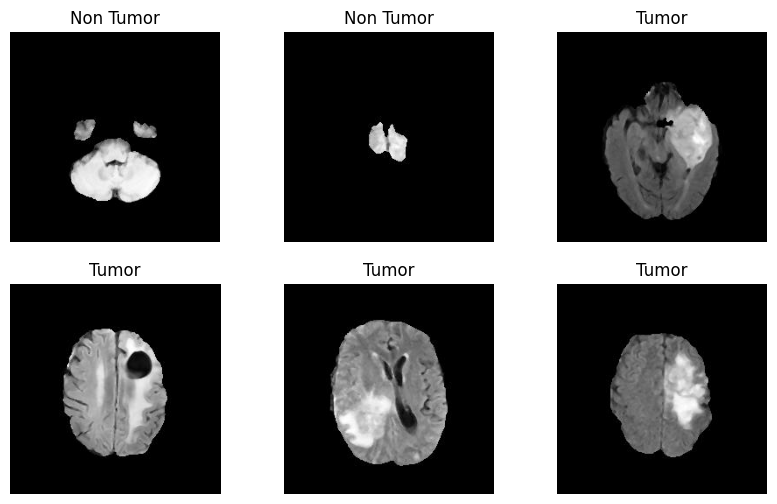

In [4]:
import matplotlib.pyplot as plt
import os, cv2
plt.figure(figsize=(10,6))
for i in range(6):
    sample = df.sample(1).iloc[0]
    img_path = os.path.join(data_dir, sample["Image"] +".jpg")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title("Tumor" if sample["Class"]==1 else "Non Tumor")
    plt.axis("off")

plt.show()

## Preprocessing the Images

We now prepare the dataset for model training:
- Resize all images to **128×128** pixels for uniformity.
- Store the images and labels in NumPy arrays.
- Convert them into training and validation sets (80/20 split) using `train_test_split`.

In [5]:
import numpy as np
img_size = 128
x=[]
y=[]

for i, row in df.iterrows():
    img_path = os.path.join(data_dir, row["Image"]+".jpg")
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    x.append(img)
    y.append(row["Class"])

x = np.array(x)
y = np.array(y)

print("X shape: ", x.shape)
print("Y shape: ", y.shape)

X shape:  (3762, 128, 128, 3)
Y shape:  (3762,)


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x,y,test_size=0.2,random_state=42,stratify=y
)
print("Training Shape: ", x_train.shape) 
print("Validation Shape: ", x_val.shape)

Training Shape:  (3009, 128, 128, 3)
Validation Shape:  (753, 128, 128, 3)


## Custom PyTorch Dataset Class

To feed the NumPy arrays into PyTorch’s DataLoader,  
we define a custom dataset class `ArrayImage` that:
- Converts NumPy images to PIL format.
- Applies data transformations (augmentation, normalization).
- Returns `(image, label)` pairs for each index.

This provides flexibility and clean integration with `DataLoader`.


In [7]:
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
class ArrayImage(Dataset):
    def __init__(self,x,y,transform=None):
        self.x=x
        self.y=y
        self.transform=transform
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        img=self.x[idx]
        if isinstance(img,np.ndarray):
            img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        label = (int(self.y[idx]))
        return img,label
    
train_transforms=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transforms=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

train_datasets=ArrayImage(x_train,y_train,transform=train_transforms)
test_datasets=ArrayImage(x_val,y_val,transform=test_transforms)

train_loader=DataLoader(train_datasets, batch_size=32, shuffle=True, num_workers=2)
test_loader=DataLoader(test_datasets, batch_size=32, shuffle=False, num_workers=2)

## Building the CNN Architecture

Here, we define a **Convolutional Neural Network (CNN)** for binary classification (Tumor vs Non-Tumor).

Architecture overview:
1. **Conv2d → ReLU → MaxPool** × 3 blocks  
2. **Flatten → Linear(128*16*16 → 128) → ReLU → Linear(128 → 2)**  
3. The final layer outputs logits for the two classes.

In [8]:
import torch.nn as nn
import torch

class CNN(nn.Module):
    def __init__(self,num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,kernel_size = 3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,kernel_size = 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,kernel_size= 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.classifier= nn.Sequential(
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(inplace=True),        
            nn.Linear(128, num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(2)
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [10]:
import torch.optim as optim 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

##  Training and Validation Loops

We train the model for **20 epochs**, tracking both training and validation loss/accuracy.

### Process:
- Set the model to `train()` mode for backpropagation.
- Compute predictions and loss.
- Update model parameters using the optimizer.
- Evaluate on the validation set with `model.eval()` and `torch.no_grad()`.

The model achieving the best validation accuracy is saved as `best_model.pth`.


In [19]:
num_epochs = 20

best_val_acc = 0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        _, predicted = torch.max(output,1)
        loss = criterion(output, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_accuracy = correct / total
    train_loss /= len(train_loader)        
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            _, predicted = torch.max(output,1)
            loss = criterion(output, labels)
            val_loss += loss.item()
            total+=labels.size(0)
            correct+= (predicted == labels).sum().item()
    val_accuracy = correct/total
    val_loss /= len(test_loader)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
        
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} \n"
          f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(),"best_model.pth")

Epoch [1/20] | Train Loss: 0.0234 | Train Accuracy: 0.9917 
Validation Loss: 0.0935 | Validation Accuracy: 0.9761
Epoch [2/20] | Train Loss: 0.0269 | Train Accuracy: 0.9904 
Validation Loss: 0.0768 | Validation Accuracy: 0.9774
Epoch [3/20] | Train Loss: 0.0174 | Train Accuracy: 0.9944 
Validation Loss: 0.0987 | Validation Accuracy: 0.9761
Epoch [4/20] | Train Loss: 0.0398 | Train Accuracy: 0.9870 
Validation Loss: 0.0853 | Validation Accuracy: 0.9774
Epoch [5/20] | Train Loss: 0.0322 | Train Accuracy: 0.9887 
Validation Loss: 0.0928 | Validation Accuracy: 0.9748
Epoch [6/20] | Train Loss: 0.0244 | Train Accuracy: 0.9924 
Validation Loss: 0.0690 | Validation Accuracy: 0.9801
Epoch [7/20] | Train Loss: 0.0147 | Train Accuracy: 0.9944 
Validation Loss: 0.0965 | Validation Accuracy: 0.9734
Epoch [8/20] | Train Loss: 0.0252 | Train Accuracy: 0.9920 
Validation Loss: 0.1043 | Validation Accuracy: 0.9761
Epoch [9/20] | Train Loss: 0.0285 | Train Accuracy: 0.9910 
Validation Loss: 0.0863 | Va

In [20]:
print("Validation Accuracy", best_val_acc)

Validation Accuracy 0.9827357237715804


##  Visualizing Training and Validation Loss


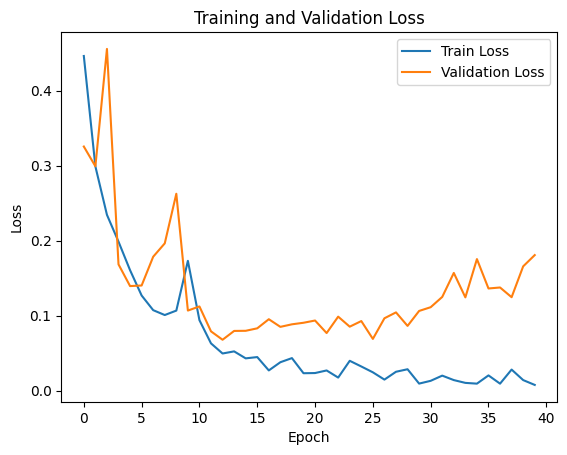

In [21]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")        
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Visualizing Training and Validation Accuracy

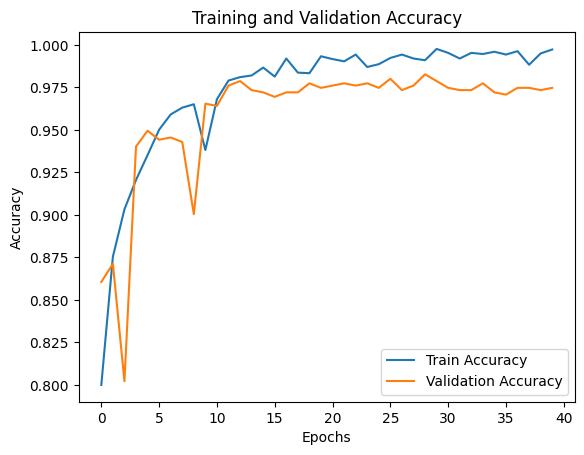

In [22]:
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()